<a href="https://colab.research.google.com/github/jenny005/Machine-Learning/blob/master/CleaningTimeSeriesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [13]:
ice_cream_heater_df=pd.read_csv('https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [14]:
#infer the frequency of the data
ice_cream_heater_df = ice_cream_heater_df.asfreq(pd.infer_freq(ice_cream_heater_df.index))

In [15]:
heater_series=ice_cream_heater_df.heater

In [16]:
heater_series

Month
2004-01-01    27
2004-02-01    18
2004-03-01    14
2004-04-01    13
2004-05-01    13
              ..
2020-02-01    34
2020-03-01    25
2020-04-01    25
2020-05-01    27
2020-06-01    24
Freq: MS, Name: heater, Length: 198, dtype: int64

In [25]:
def plot_series(series): 
  plt.figure(figsize=(10,4))
  plt.plot(heater_series,color='red')
  plt.title('Trends', fontsize=20)
  plt.ylabel('Search Frequency for "Heater"', fontsize=16)
  for year in range(2004,2021):
      plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

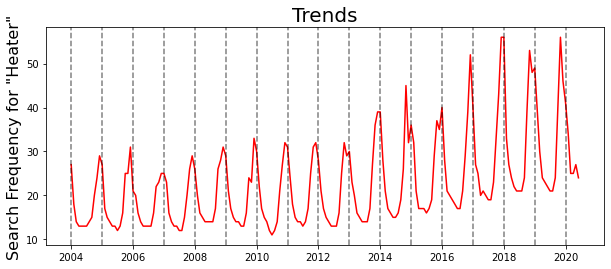

In [26]:
plot_series(heater_series)

**Normalize**

In [27]:
avg, dev = heater_series.mean(),heater_series.std()

In [28]:
heater_series=(heater_series-avg)/dev

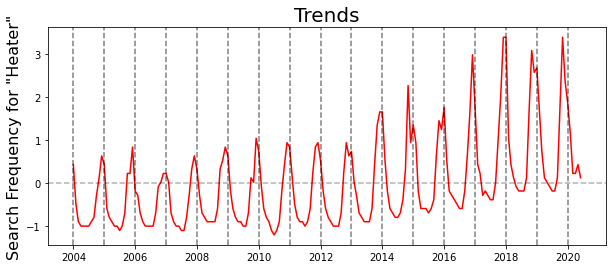

In [29]:
plot_series(heater_series)
plt.axhline(0,linestyle='--',color='k',alpha=0.3)

**Take First Difference to Remove Stationarity**

In [30]:
heater_series=heater_series.diff().dropna()

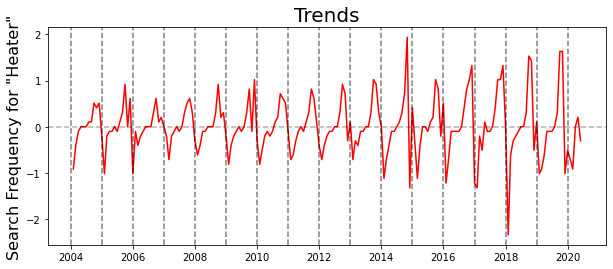

In [31]:
plot_series(heater_series)
plt.axhline(0,linestyle='--',color='k',alpha=0.3)

**Remove Increasing Volatility**

In [32]:
annual_volatility=heater_series.groupby(heater_series.index.year).std()

In [33]:
annual_volatility

Month
2004    0.415481
2005    0.474527
2006    0.400148
2007    0.359839
2008    0.396182
2009    0.499810
2010    0.459566
2011    0.443924
2012    0.471104
2013    0.503587
2014    0.855743
2015    0.569441
2016    0.719843
2017    0.830886
2018    0.987221
2019    0.892991
2020    0.426657
Name: heater, dtype: float64

In [34]:
heater_annual_vol=heater_series.index.map(lambda d:annual_volatility.loc[d.year])

In [35]:
heater_annual_vol

Float64Index([0.41548104705328814, 0.41548104705328814, 0.41548104705328814,
              0.41548104705328814, 0.41548104705328814, 0.41548104705328814,
              0.41548104705328814, 0.41548104705328814, 0.41548104705328814,
              0.41548104705328814,
              ...
               0.8929910269067826,  0.8929910269067826,  0.8929910269067826,
               0.8929910269067826, 0.42665652301411977, 0.42665652301411977,
              0.42665652301411977, 0.42665652301411977, 0.42665652301411977,
              0.42665652301411977],
             dtype='float64', name='Month', length=197)

In [36]:
heater_series=heater_series/heater_annual_vol

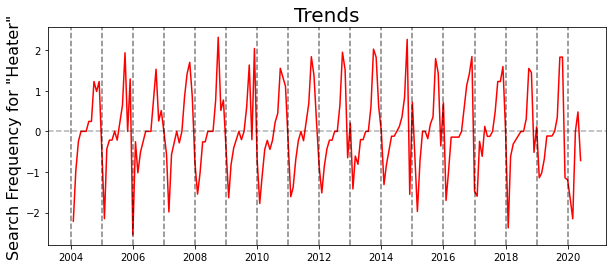

In [37]:
plot_series(heater_series)
plt.axhline(0,linestyle='--',color='k',alpha=0.3)

**Remove Seasonality**

In [38]:
month_avgs = heater_series.groupby(heater_series.index.month).mean()

In [39]:
month_avgs

Month
1    -0.428360
2    -1.483129
3    -1.063595
4    -0.442926
5    -0.121663
6    -0.128425
7    -0.107093
8     0.075720
9     0.544638
10    1.613170
11    1.183118
12    0.491641
dtype: float64

In [40]:
heater_month_avg=heater_series.index.map(lambda d:month_avgs.loc[d.month])

In [41]:
heater_month_avg

Float64Index([  -1.483129277176665,  -1.0635953355687688, -0.44292637101368243,
               -0.1216626157216479, -0.12842542811874375, -0.10709260508002617,
               0.07572031336904017,   0.5446384049209764,   1.6131699911888606,
                1.1831180641276993,
              ...
                0.5446384049209764,   1.6131699911888606,   1.1831180641276993,
                0.4916411242912191,  -0.4283597874466263,   -1.483129277176665,
               -1.0635953355687688, -0.44292637101368243,  -0.1216626157216479,
              -0.12842542811874375],
             dtype='float64', name='Month', length=197)

In [43]:
heater_series=heater_series-heater_month_avg

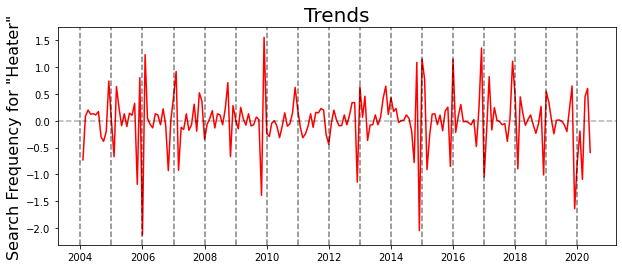

In [44]:
plot_series(heater_series)
plt.axhline(0,linestyle='--',color='k',alpha=0.3)